In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class Ising_model:

    kb = 1  #1.38064852e-23
    
    def __init__(self, L, T):
        self.L = L
        self.T = T
        spin_conf = np.zeros((L, L))
        for i in range(L):
            for j in range(L):
                spin = np.random.randint(-1, 2)
                while spin == 0:
                    spin = np.random.randint(-1, 2)
                spin_conf[i][j] = spin
        self.s = spin_conf

    def visual(self, verbose=True):
        L = self.L
        demo = np.zeros(np.shape(self.s), dtype=str)
        num_up, num_down = 0, 0
        for i in range(L):
            for j in range(L):
                if self.s[i][j] == 1.0:
                    demo[i][j] = '↑'
                    num_up += 1
                elif self.s[i][j] == -1.0:
                    demo[i][j] = '↓'
                    num_down += 1
        print(demo)
        if verbose == True:
            print('Spin_up=%i ;Spin_down=%i' % (num_up, num_down))

    def energy(self):
        L = self.L
        E = 0
        J = 1
        for i in range(L):
            for j in range(L):
                E += self.s[i, j] * (self.s[
                    (i + 1) % L, j] + self.s[i, (j + 1) % L])
        energy = -J * E
        return energy

    def magnet(self):
        L = self.L
        M = 0.0
        for i in range(L):
            for j in range(L):
                M += self.s[i, j]
        return M

    def dE(self, i, j):
        L = self.L
        NB = self.s[(i + 1) % L, j] + self.s[i, (j + 1) % L] + self.s[
            (i - 1) % L, j] + self.s[i, (j - 1) % L]
        dE = 2 * self.s[i, j] * NB
        return dE

    def mc_method_sq(self, verbose1=False, verbose2=False):
        T = self.T
        kb = self.kb
        L = self.L
        accept = 0
        beta = 1 / T / kb
        for i in range(L):
            for j in range(L):
                if self.dE(i, j) < 0:
                    self.s[i][j] *= -1
                    accept += 1
                elif self.dE(i, j) >= 0:
                    prob = np.exp(-beta * self.dE(i, j))
                    if np.random.random() < prob:
                        self.s[i][j] *= -1
                        accept += 1
                if verbose1 == True:
                    print('\n[%i, %i], dE=%.1f' % (i, j, self.dE(i, j)))
                    self.visual()
        if verbose2 == True:
            print('L=%i, T=%i, Accept_rate=%.2f' % (L, T,
                                                    (100 * accept / L**2)) +
                  '%')
        return self.s

    def mc_method_rnd(self, verbose1=False, verbose2=False):
        T = self.T
        kb = self.kb
        L = self.L
        accept = 0
        beta = 1 / T / kb
        for n in range(L*L):
            i = np.random.randint(L)
            j = np.random.randint(L)
            if self.dE(i, j) < 0:
                self.s[i][j] *= -1
                accept += 1
            elif self.dE(i, j) >= 0:
                prob = np.exp(-beta * self.dE(i, j))
                if np.random.random() < prob:
                    self.s[i][j] *= -1
                    accept += 1
            if verbose1 == True:
                print('\n[%i, %i], dE=%.1f' % (i, j, self.dE(i, j)))
                self.visual()
        if verbose2 == True:
            print('L=%i, T=%i, Accept_rate=%.2f' % (L, T,
                                                    (100 * accept / L**2)) +
                  '%')
        return self.s
    
    @staticmethod
    def get_diff_T_params(L, T_list, N_rnd, N_eq=100, plot=True, polarized=True):
        '''
        input: L, T_list (diff T), N_rnd
        output: C, Chi, Eng, Mag 
        '''
        Mag, Eng, C, Chi = [], [], [], []
        for T in T_list:
            sample = Ising_model(L, T)
            if polarized == True:
                sample.s = np.ones((sample.L, sample.L))
            
            for run in range(N_eq):
                sample.mc_method_sq()
            
            mag, eng, mag_2, eng_2 = [], [], [], []
            for run in range(N_rnd):
                sample.mc_method_sq()
                mag.append(abs(sample.magnet()))
                eng.append(sample.energy())
                mag_2.append(sample.magnet()**2)
                eng_2.append(sample.energy()**2)

            mean_mag = sum(mag) / len(mag)
            mean_eng = sum(eng) / len(eng)
            mean_mag_2 = sum(mag_2) / len(mag_2)
            mean_eng_2 = sum(eng_2) / len(eng_2)

            C.append(((mean_eng_2 - mean_eng**2) / sample.kb / T / T) / (sample.L**2))
            Chi.append(((mean_mag_2 - mean_mag**2) / sample.kb / T) / (sample.L**2))
            Eng.append(mean_eng / sample.L**2)
            Mag.append(mean_mag / sample.L**2)
            
        if plot == True:
            axes[0, 0].plot(T_list, Eng, '-o', label=('L=%i' % L))
            axes[0, 1].plot(T_list, C, '-o', label=('L=%i' % L))
            axes[1, 0].plot(T_list, Mag, '-o', label=('L=%i' % L))
            axes[1, 1].plot(T_list, Chi, '-o', label=('L=%i' % L))
        
        return C, Chi, Eng, Mag

In [ ]:
L_list = [2, 4, 8, 16, 32]
T_list = list(np.arange(1,2,0.5)) + list(np.arange(2,3,0.05)) + list(np.arange(3,5,0.5))

para_list = [r'<$m^2$>', '<Chi>/N']
N_rnd = 2000

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

Q_max = []
for L in L_list:
    print('L=%i' % L)
    C, Chi, Eng, Mag = Ising_model.get_diff_T_params(L, T_list, N_rnd, plot=False)
    
    Mag_2 = []
    for i in range(len(Mag)):
        Mag_2.append(Mag[i]**2)
    
    axes[0].plot(T_list, Mag_2, '-o', label=('L=%i' % L))
    axes[1].plot(T_list, Chi, '-o', label=('L=%i' % L))
    
    Q_max.append(max(Chi))
    
    for i in range(len(axes)):
        axes[i].set_ylabel(para_list[i], fontsize=18)
        axes[i].set_xlabel('Temperature (k)')
        axes[i].legend()
plt.show()

L=2
L=4
L=8
L=16
L=32


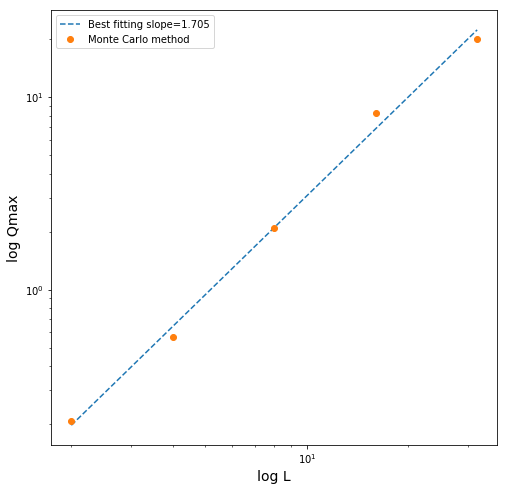

In [14]:
L = np.array(L_list)
Q = np.array(Q_max)

L_log = np.log(L)
Q_log = np.log(Q)

coeffs = np.polyfit(L_log,Q_log,deg=1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(np.log(x)))

plt.figure(figsize=(8,8))
plt.loglog(L, yfit(L), '--', label='Best fitting slope=%.3f' % poly.c[0])
plt.loglog(L, Q, 'o', label='Monte Carlo method')

plt.xlabel('log L', fontsize=14)
plt.ylabel('log Qmax', fontsize=14)
plt.legend()
plt.show()